# 03_create_patches_v2

In [1]:
from pathlib import Path
import os
workdir = Path("/Users/Anthony/Data and Analysis Local/NYS_Wetlands_GHG/")
print(workdir)
os.chdir(workdir)
current_working_dir = Path.cwd()
print(f"Current working directory is now: {current_working_dir}")

/Users/Anthony/Data and Analysis Local/NYS_Wetlands_GHG
Current working directory is now: /Users/Anthony/Data and Analysis Local/NYS_Wetlands_GHG


In [2]:
import rasterio
import geopandas as gpd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [3]:
# === CONFIGURATION ===
naip_path = "Data/NAIP/HUC_NAIP_Processed/cluster_208_huc_041402011002_NAIP_metrics.tif"
dem_path = "Data/TerrainProcessed/HUC_DEMs/cluster_208_huc_041402011002.tif"
chm_path = "Data/CHMs/HUC_CHMs/cluster_208_huc_041402011002_CHM.tif"
slp_path = "Data/TerrainProcessed/HUC_TerrainMetrics/cluster_208_huc_041402011002_terrain_slp_5m.tif"

labels_path = "Data/Training_Data/cluster_208_huc_041402011002_labels.tif"
wetlands_path = "Data/Training_Data/HUC_Extracted_Training_Data/cluster_208_huc_041402011002_NWI.gpkg"
output_dir = Path("Data/Patches_v2")

patch_size = 256
max_offset = 32  # Random offset from centroid (pixels) to add variety
background_patches = 120  # Number of random background patches to include
val_split = 0.2
random_seed = 42

In [4]:
# === CREATE OUTPUT DIRECTORY ===
output_dir.mkdir(parents=True, exist_ok=True)

# === LOAD ALL BANDS ===
print("Loading rasters...")

# Track band names as we load each raster
band_names = []

with rasterio.open(naip_path) as src:
    naip = src.read()  # Shape: (6, H, W)
    naip_bands = list(src.descriptions)
    band_names.extend(naip_bands)
    print(f"NAIP: {naip_bands}")
    transform = src.transform  # For converting coordinates to pixels

with rasterio.open(dem_path) as src:
    dem = src.read()  # Shape: (1, H, W)
    dem_bands = ['dem']  # Rename from 'Band_1'
    band_names.extend(dem_bands)
    print(f"DEM: {dem_bands}")

with rasterio.open(chm_path) as src:
    chm = src.read()  # Shape: (1, H, W)
    chm_bands = ['chm']
    band_names.extend(chm_bands)
    print(f"CHM: {chm_bands}")

with rasterio.open(slp_path) as src:
    slp = src.read()  # Shape: (3, H, W)
    slp_bands = list(src.descriptions)
    band_names.extend(slp_bands)
    print(f"Terrain: {slp_bands}")

with rasterio.open(labels_path) as src:
    labels = src.read(1)  # Shape: (H, W)

# Stack inputs in same order as band_names: naip, dem, chm, slp
inputs = np.vstack([naip, dem, chm, slp])
_, height, width = inputs.shape
print(f"\nInput stack shape: {inputs.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Band names ({len(band_names)}): {band_names}")

Loading rasters...
NAIP: ['r', 'g', 'b', 'nir', 'ndvi', 'ndwi']
DEM: ['dem']
CHM: ['chm']
Terrain: ['slope_5m', 'TPI_5m', 'Geomorph_5m']

Input stack shape: (11, 12000, 18000)
Labels shape: (12000, 18000)
Band names (11): ['r', 'g', 'b', 'nir', 'ndvi', 'ndwi', 'dem', 'chm', 'slope_5m', 'TPI_5m', 'Geomorph_5m']


In [5]:
print(f"The max values are: {np.nanmax(dem), np.nanmax(slp[0]), np.nanmax(slp[1]), np.nanmax(chm)}")
print(f"The min values are: {np.nanmin(dem), np.nanmin(slp[0]), np.nanmin(slp[1]), np.nanmin(chm)}")

The max values are: (np.float32(565.3812), np.float32(67.68762), np.float32(0.23091507), np.float32(45.991898))
The min values are: (np.float32(311.6553), np.float32(0.0), np.float32(-0.13051224), np.float32(0.0))


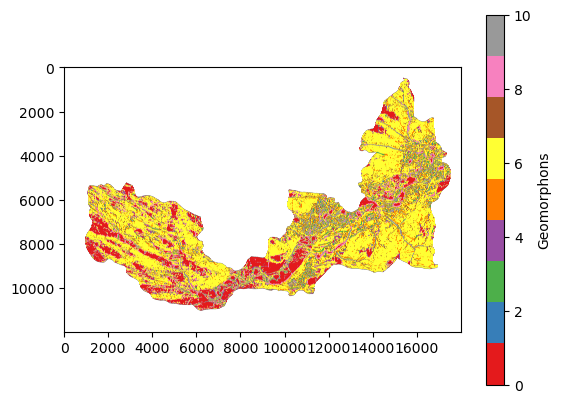

In [6]:
plt.imshow(slp[2], vmin = 0, vmax=10, cmap="Set1")
plt.colorbar(label='Geomorphons')

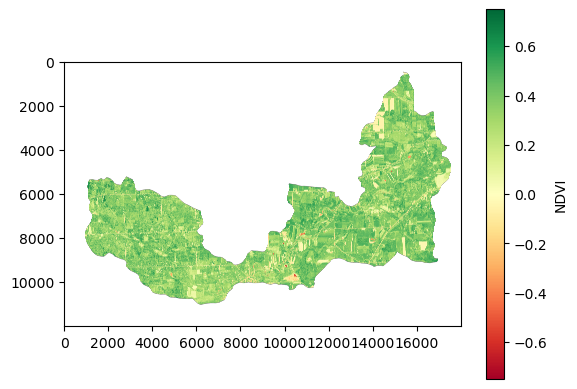

In [7]:
plt.imshow(naip[4], cmap='RdYlGn', vmin=-0.75, vmax=0.75)
plt.colorbar(label='NDVI')
plt.show()

In [8]:
# === LOAD WETLAND POLYGONS ===
print("\nLoading wetland polygons...")
wetlands = gpd.read_file(wetlands_path)
print(f"Number of wetland polygons: {len(wetlands)}")

# === HELPER FUNCTION: EXTRACT PATCH ===
def extract_patch(center_row, center_col, patch_size, inputs, labels):
    """
    Extract a patch centered at (center_row, center_col).
    Returns None if patch would be out of bounds or contains NaN.
    """
    half = patch_size // 2
    
    # Calculate bounds
    row_start = center_row - half
    row_end = center_row + half
    col_start = center_col - half
    col_end = center_col + half
    
    # Check bounds
    if row_start < 0 or row_end > height or col_start < 0 or col_end > width:
        return None, None
    
    # Extract patches
    X_patch = inputs[:, row_start:row_end, col_start:col_end]
    y_patch = labels[row_start:row_end, col_start:col_end]
    
    # Check for NaN
    if np.any(np.isnan(X_patch)):
        return None, None
    
    return X_patch, y_patch


Loading wetland polygons...
Number of wetland polygons: 296


In [9]:
# === EXTRACT WETLAND-CENTERED PATCHES ===
print("\nExtracting wetland-centered patches...")
np.random.seed(random_seed)

wetland_patches_X = []
wetland_patches_y = []
skipped_count = 0

for idx, row in wetlands.iterrows():
    # Get centroid coordinates
    centroid = row.geometry.centroid
    
    # Convert geographic coordinates to pixel coordinates
    # transform: (x, y) -> (col, row)
    col, row_px = ~transform * (centroid.x, centroid.y)
    col, row_px = int(col), int(row_px)
    
    # Add random offset for variety
    offset_row = np.random.randint(-max_offset, max_offset + 1)
    offset_col = np.random.randint(-max_offset, max_offset + 1)
    center_row = row_px + offset_row
    center_col = col + offset_col
    
    # Extract patch
    X_patch, y_patch = extract_patch(center_row, center_col, patch_size, inputs, labels)
    
    if X_patch is not None:
        wetland_patches_X.append(X_patch)
        wetland_patches_y.append(y_patch)
    else:
        skipped_count += 1

print(f"Wetland-centered patches extracted: {len(wetland_patches_X)}")
print(f"Skipped (out of bounds or NaN): {skipped_count}")


Extracting wetland-centered patches...
Wetland-centered patches extracted: 258
Skipped (out of bounds or NaN): 38


In [10]:
# === EXTRACT RANDOM BACKGROUND PATCHES ===
print(f"\nExtracting {background_patches} random background patches...")

background_patches_X = []
background_patches_y = []
attempts = 0
max_attempts = background_patches * 10  # Limit attempts to avoid infinite loop

while len(background_patches_X) < background_patches and attempts < max_attempts:
    attempts += 1
    
    # Random center point
    center_row = np.random.randint(patch_size // 2, height - patch_size // 2)
    center_col = np.random.randint(patch_size // 2, width - patch_size // 2)
    
    # Extract patch
    X_patch, y_patch = extract_patch(center_row, center_col, patch_size, inputs, labels)
    
    if X_patch is None:
        continue
    
    # Only keep if it's purely background (no wetland pixels)
    if not np.any(y_patch > 0):
        background_patches_X.append(X_patch)
        background_patches_y.append(y_patch)

print(f"Background patches extracted: {len(background_patches_X)}")


Extracting 120 random background patches...
Background patches extracted: 120


In [11]:
# === COMBINE AND SPLIT ===
print("\nCombining and splitting data...")

all_X = wetland_patches_X + background_patches_X
all_y = wetland_patches_y + background_patches_y

X_array = np.array(all_X, dtype=np.float32)
y_array = np.array(all_y, dtype=np.uint8)

print(f"Total patches: {len(X_array)}")
print(f"X shape: {X_array.shape}")  # (N, 7, 256, 256)
print(f"y shape: {y_array.shape}")  # (N, 256, 256)

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(
    X_array, y_array, 
    test_size=val_split, 
    random_state=random_seed
)

print(f"\nTrain patches: {len(X_train)}")
print(f"Validation patches: {len(X_val)}")


Combining and splitting data...
Total patches: 378
X shape: (378, 11, 256, 256)
y shape: (378, 256, 256)

Train patches: 302
Validation patches: 76


In [12]:
import json

# === SAVE PATCHES ===
np.save(output_dir / "X_train.npy", X_train)
np.save(output_dir / "y_train.npy", y_train)
np.save(output_dir / "X_val.npy", X_val)
np.save(output_dir / "y_val.npy", y_val)

# === COMPUTE BAND STATISTICS FROM TRAINING DATA ===
print("Computing band statistics from training data...")
band_stats = {}
for i, name in enumerate(band_names):
    band_data = X_train[:, i, :, :]
    band_stats[name] = {
        "min": float(np.nanmin(band_data)),
        "max": float(np.nanmax(band_data)),
        "mean": float(np.nanmean(band_data)),
        "std": float(np.nanstd(band_data)),
    }
    print(f"  {name}: min={band_stats[name]['min']:.3f}, max={band_stats[name]['max']:.3f}")

# Define normalization strategy for each band type
normalization = {}
for name in band_names:
    if name in ['r', 'g', 'b', 'nir']:
        normalization[name] = {"type": "divide", "value": 255.0}
    elif name in ['ndvi', 'ndwi']:
        normalization[name] = {"type": "shift_scale", "shift": 1.0, "scale": 2.0}  # (x + 1) / 2
    else:
        # Min-max normalization using computed stats
        normalization[name] = {
            "type": "minmax",
            "min": band_stats[name]["min"],
            "max": band_stats[name]["max"]
        }

# === SAVE METADATA ===
metadata = {
    "in_channels": int(X_train.shape[1]),
    "num_classes": 5,
    "patch_size": patch_size,
    "band_names": band_names,
    "class_names": ["Background", "EMW", "FSW", "SSW", "OWW"],
    "n_train": int(len(X_train)),
    "n_val": int(len(X_val)),
    "band_stats": band_stats,
    "normalization": normalization,
}

with open(output_dir / "metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)

print(f"\nSaved patches to {output_dir}")
print(f"Saved metadata with band statistics and normalization parameters")

Computing band statistics from training data...
  r: min=0.000, max=255.000
  g: min=20.000, max=255.000
  b: min=55.000, max=255.000
  nir: min=12.000, max=254.000
  ndvi: min=-0.733, max=1.000
  ndwi: min=-0.628, max=0.771
  dem: min=311.703, max=497.037
  chm: min=0.000, max=38.872
  slope_5m: min=0.000, max=40.392
  TPI_5m: min=-0.067, max=0.080
  Geomorph_5m: min=1.000, max=10.000

Saved patches to Data/Patches_v2
Saved metadata with band statistics and normalization parameters


In [13]:
# === CLASS DISTRIBUTION IN TRAINING SET ===
print("\nClass distribution in training patches (pixel counts):")
unique, counts = np.unique(y_train, return_counts=True)
total = y_train.size
for val, count in zip(unique, counts):
    class_name = {0: 'Background', 1: 'EMW', 2: 'FSW', 3: 'SSW', 4: 'OWW'}.get(val, 'Unknown')
    pct = (count / total) * 100
    print(f"  {class_name}: {count:,} pixels ({pct:.2f}%)")


Class distribution in training patches (pixel counts):
  Background: 16,512,968 pixels (83.43%)
  EMW: 705,145 pixels (3.56%)
  FSW: 1,171,525 pixels (5.92%)
  SSW: 1,144,319 pixels (5.78%)
  OWW: 257,915 pixels (1.30%)



Generating patch visualization...


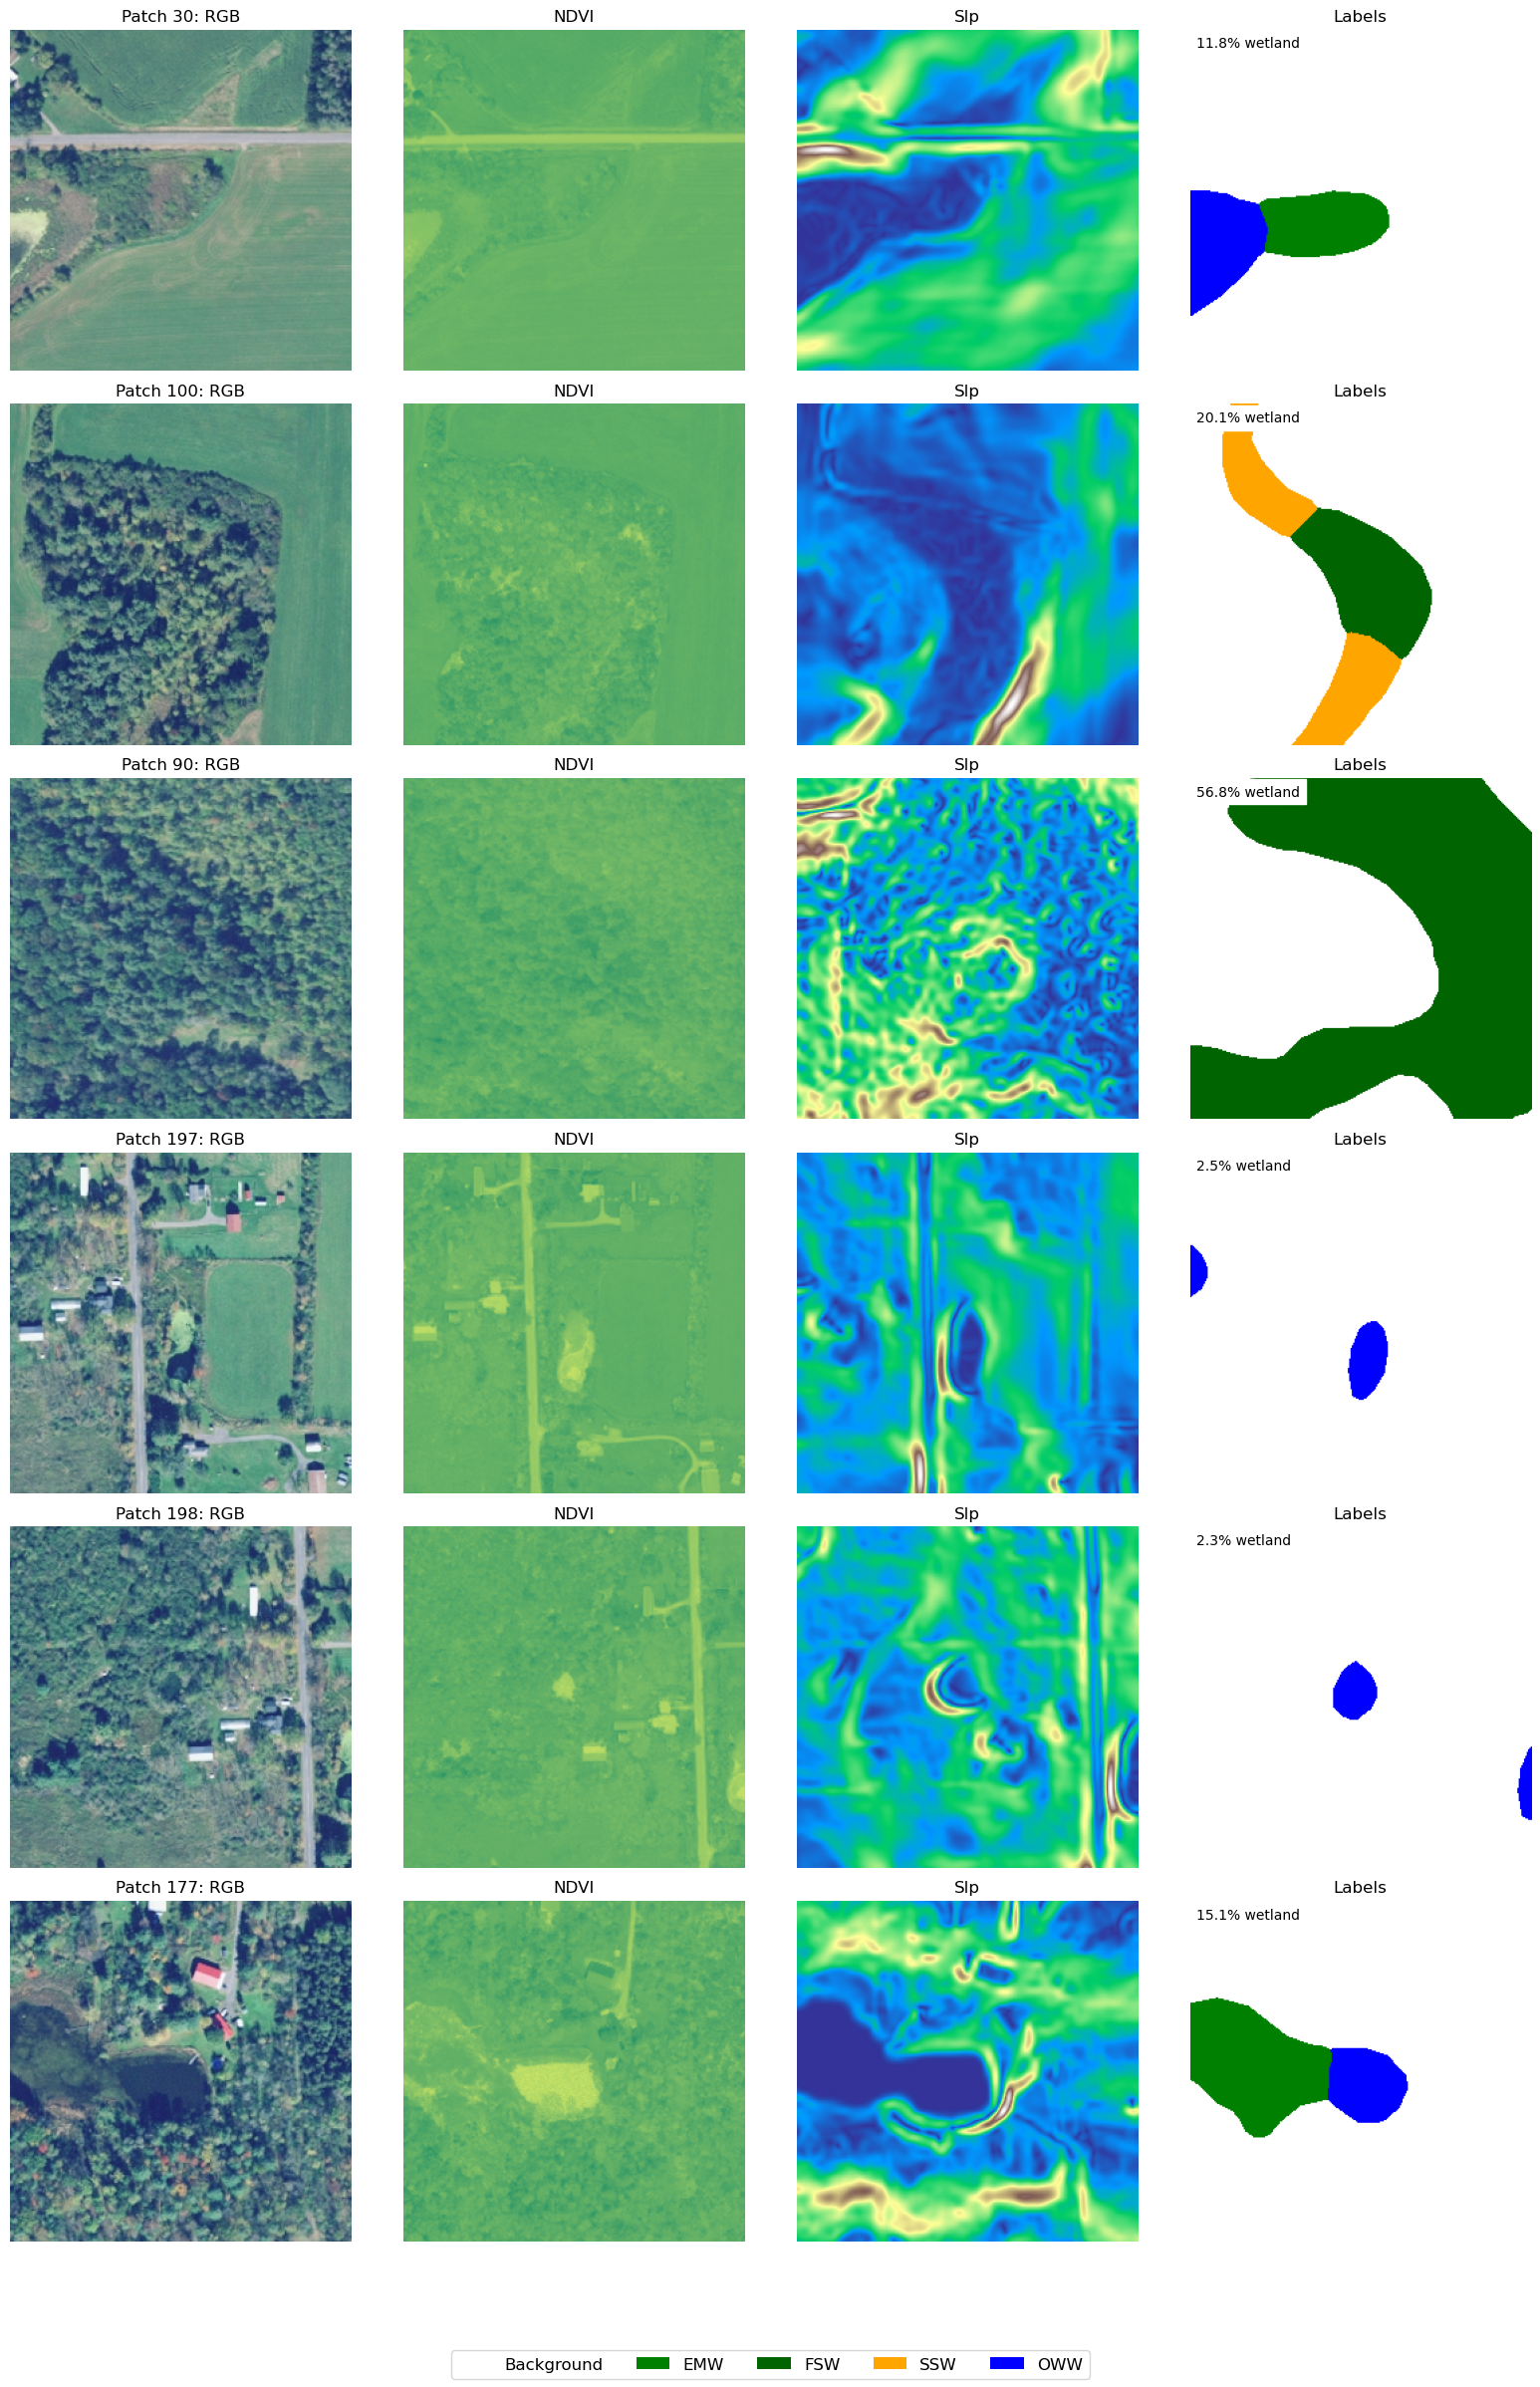

Saved visualization to Data/Patches_v2/patch_samples.png


In [14]:

# === VISUALIZE SAMPLE PATCHES ===
print("\nGenerating patch visualization...")

# Setup
class_names = ['Background', 'EMW', 'FSW', 'SSW', 'OWW']
colors = ['white', 'green', 'darkgreen', 'orange', 'blue']
cmap = ListedColormap(colors)

# Select random patches to visualize
np.random.seed(123)
n_samples = 6
sample_indices = np.random.choice(len(wetland_patches_X), n_samples, replace=False)

fig, axes = plt.subplots(n_samples, 4, figsize=(16, n_samples * 4))

for row, idx in enumerate(sample_indices):
    X_patch = wetland_patches_X[idx]
    y_patch = wetland_patches_y[idx]
    
    # RGB (bands 0, 1, 2) - normalize for display
    rgb = X_patch[0:3].transpose(1, 2, 0)  # (3, H, W) -> (H, W, 3)
    rgb = np.nan_to_num(rgb / 255.0, nan=0)
    
    # NDVI (band 5)
    ndvi = X_patch[5]
    
    # DEM (band 6)
    dem = X_patch[6]

    # Slope (band) 
    slp = X_patch[8]
    
    # Plot RGB
    axes[row, 0].imshow(rgb)
    axes[row, 0].set_title(f"Patch {idx}: RGB")
    axes[row, 0].axis('off')
    
    # Plot NDVI
    axes[row, 1].imshow(ndvi, cmap='summer', vmin=-0.75, vmax=0.75)
    axes[row, 1].set_title("NDVI")
    axes[row, 1].axis('off')
    
    # Plot DEM
    axes[row, 2].imshow(slp, cmap='terrain')
    axes[row, 2].set_title("Slp")
    axes[row, 2].axis('off')
    
    # Plot labels
    im = axes[row, 3].imshow(y_patch, cmap=cmap, vmin=0, vmax=4)
    axes[row, 3].set_title("Labels")
    axes[row, 3].axis('off')
    
    # Count wetland pixels in this patch
    wetland_pixels = np.sum(y_patch > 0)
    total_pixels = y_patch.size
    wetland_pct = (wetland_pixels / total_pixels) * 100
    
    # Add text showing wetland coverage
    axes[row, 3].text(
        0.02, 0.98, f"{wetland_pct:.1f}% wetland",
        transform=axes[row, 3].transAxes,
        fontsize=10, color='black', backgroundcolor='white',
        verticalalignment='top'
    )

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=n) for c, n in zip(colors, class_names)]
fig.legend(handles=legend_elements, loc='lower center', ncol=5, fontsize=12)

plt.tight_layout()
plt.subplots_adjust(bottom=0.06)
plt.savefig(output_dir / "patch_samples.png", dpi=150)
plt.show()

print(f"Saved visualization to {output_dir / 'patch_samples.png'}")